In [1]:
from keras.datasets import mnist

(train_x, train_y), (_,_) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [2]:
import matplotlib.pyplot as plt

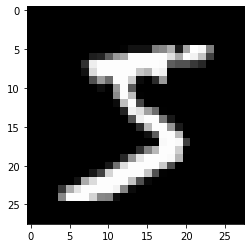

In [3]:
plt.imshow(train_x[0],cmap = "gray")

In [4]:
import numpy as np

np.max(train_x)

255

In [5]:
np.unique(train_y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [6]:
def condition_labels(n):
  l = ["zero","one","two","three","four","five","six","seven","eight","nine"]
  return l[n]

In [7]:
conditions = [condition_labels(e) for e in train_y]

In [9]:
del train_y

In [10]:
d = {}
def create_tokens(a):
  i=0
  for e in a:
    if e not in d.keys():
      d[e] = i
      i+=1
  tokens = []
  print(d)
  for w in a:
    tokens.append([d[w]])
  
  return np.array(tokens)


In [11]:
tokens = np.array(create_tokens(conditions))

{'five': 0, 'zero': 1, 'four': 2, 'one': 3, 'nine': 4, 'two': 5, 'three': 6, 'six': 7, 'seven': 8, 'eight': 9}


In [12]:
tokens

array([[0],
       [1],
       [2],
       ...,
       [0],
       [7],
       [9]])

In [13]:
from keras.layers import Dense, LeakyReLU, Reshape,concatenate, Flatten, Lambda, Concatenate,Embedding,Conv2DTranspose,Input,Concatenate,Conv2D,MaxPooling2D,Dropout
from keras.models import Sequential
from keras import Model

In [14]:
def define_generator(name):
  noise = Input((100))
  condition = Input((1,))
  
  #embeds
  emb = Embedding(10,100,input_length=1)(condition)
  emb_to_dens = Dense(7*7)(emb)
  emb_to_dens_reshaped = Reshape((7,7,1))(emb_to_dens)

  #noise to filters
  n_nodes = 50 * 7 * 7
  d =  Dense(n_nodes)(noise)
  reshaped_d = Reshape((7,7,50))(d)

  #joining
  #7x7x51
  l = Concatenate()([reshaped_d,emb_to_dens_reshaped])

  #14x14x128
  l = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(l)
  l = LeakyReLU(alpha=0.2)(l)

  #28x28x64
  l = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same')(l)
  l = LeakyReLU(alpha=0.2)(l)

  output = Conv2D(1, (7,7), activation='tanh', padding='same')(l)

  return Model([noise,condition],output,name=name)

In [15]:
from tensorflow.keras.utils import plot_model
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def model_plotter(model):
  plot_model(
      model,
      to_file="model.png",
      show_shapes=True,
      show_dtype=True,
      show_layer_names=True,
      rankdir="TB",
      expand_nested=True,
      dpi=96,
      layer_range=None,
#       show_layer_activations=True,
  )
  figure(figsize=(100,100))
  plt.imshow(np.asarray(Image.open("model.png")))
  plt.axis("off")
  plt.show()  


In [16]:
from tensorflow.keras.optimizers import Adam


def define_discriminator(name):
  image = Input((28,28,1))
  condition = Input((1,))

  #same embed block as generator
  emb = Embedding(10,100,input_length=1)(condition)
  emb_to_dens = Dense(7*7)(emb)
  emb_to_dens_reshaped = Reshape((7,7,1))(emb_to_dens)
  
  #14x14x64
  l = Conv2D(100, (3,3), strides=(2, 2), padding='same')(image)
  l = LeakyReLU(alpha=0.2)(l)
  l = Dropout(0.4)(l)
 
  #7x7x50
  l = Conv2D(50, (3,3), strides=(2, 2), padding='same')(l)
  l = LeakyReLU(alpha=0.2)(l)
  l = Dropout(0.4)(l)

  #joining
  l = Concatenate()([l,emb_to_dens_reshaped])

  l = Flatten()(l)
  l = Dense(100)(l)
  l = Dense(100)(l)
  l = Dense(100)(l)
  
  output = Dense(1, activation='sigmoid')(l)

  opt = Adam(learning_rate=0.0002, beta_1=0.5)

  model = Model([image,condition],output,name=name)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
 
  return model

In [17]:
def get_generator_training_batch(batch,indexes):
  noise = np.random.uniform(-1., 1., size=[batch, 100])
  conditions = tokens[indexes]
  return  [noise,conditions]

In [18]:
def get_discriminator_batch(batch,indexes,fake):
  if(fake != True):
    conditions = tokens[indexes]
    images = train_x[indexes]
    return [images,conditions]
  else:
    conditions = tokens[indexes]
    noise = np.random.uniform(-1., 1., size=[batch, 100])
    images = generator.predict([noise,conditions])
    return [images,conditions]
  

In [19]:
discriminator = define_discriminator(name = "discriminator")
discriminator.trainable = False

generator = define_generator(name = "generator")

noise = Input((100,),name = "noise input")
condition = Input((1,),name = "condition input")

output = generator([noise,condition])
output = discriminator([output,condition])

gan = Model([noise,condition],output)
opt = Adam(learning_rate=0.0002, beta_1=0.5)

gan.compile(loss='binary_crossentropy', optimizer=opt)

2022-08-26 17:59:58.252897: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-26 17:59:58.383143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-26 17:59:58.383951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-26 17:59:58.385333: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

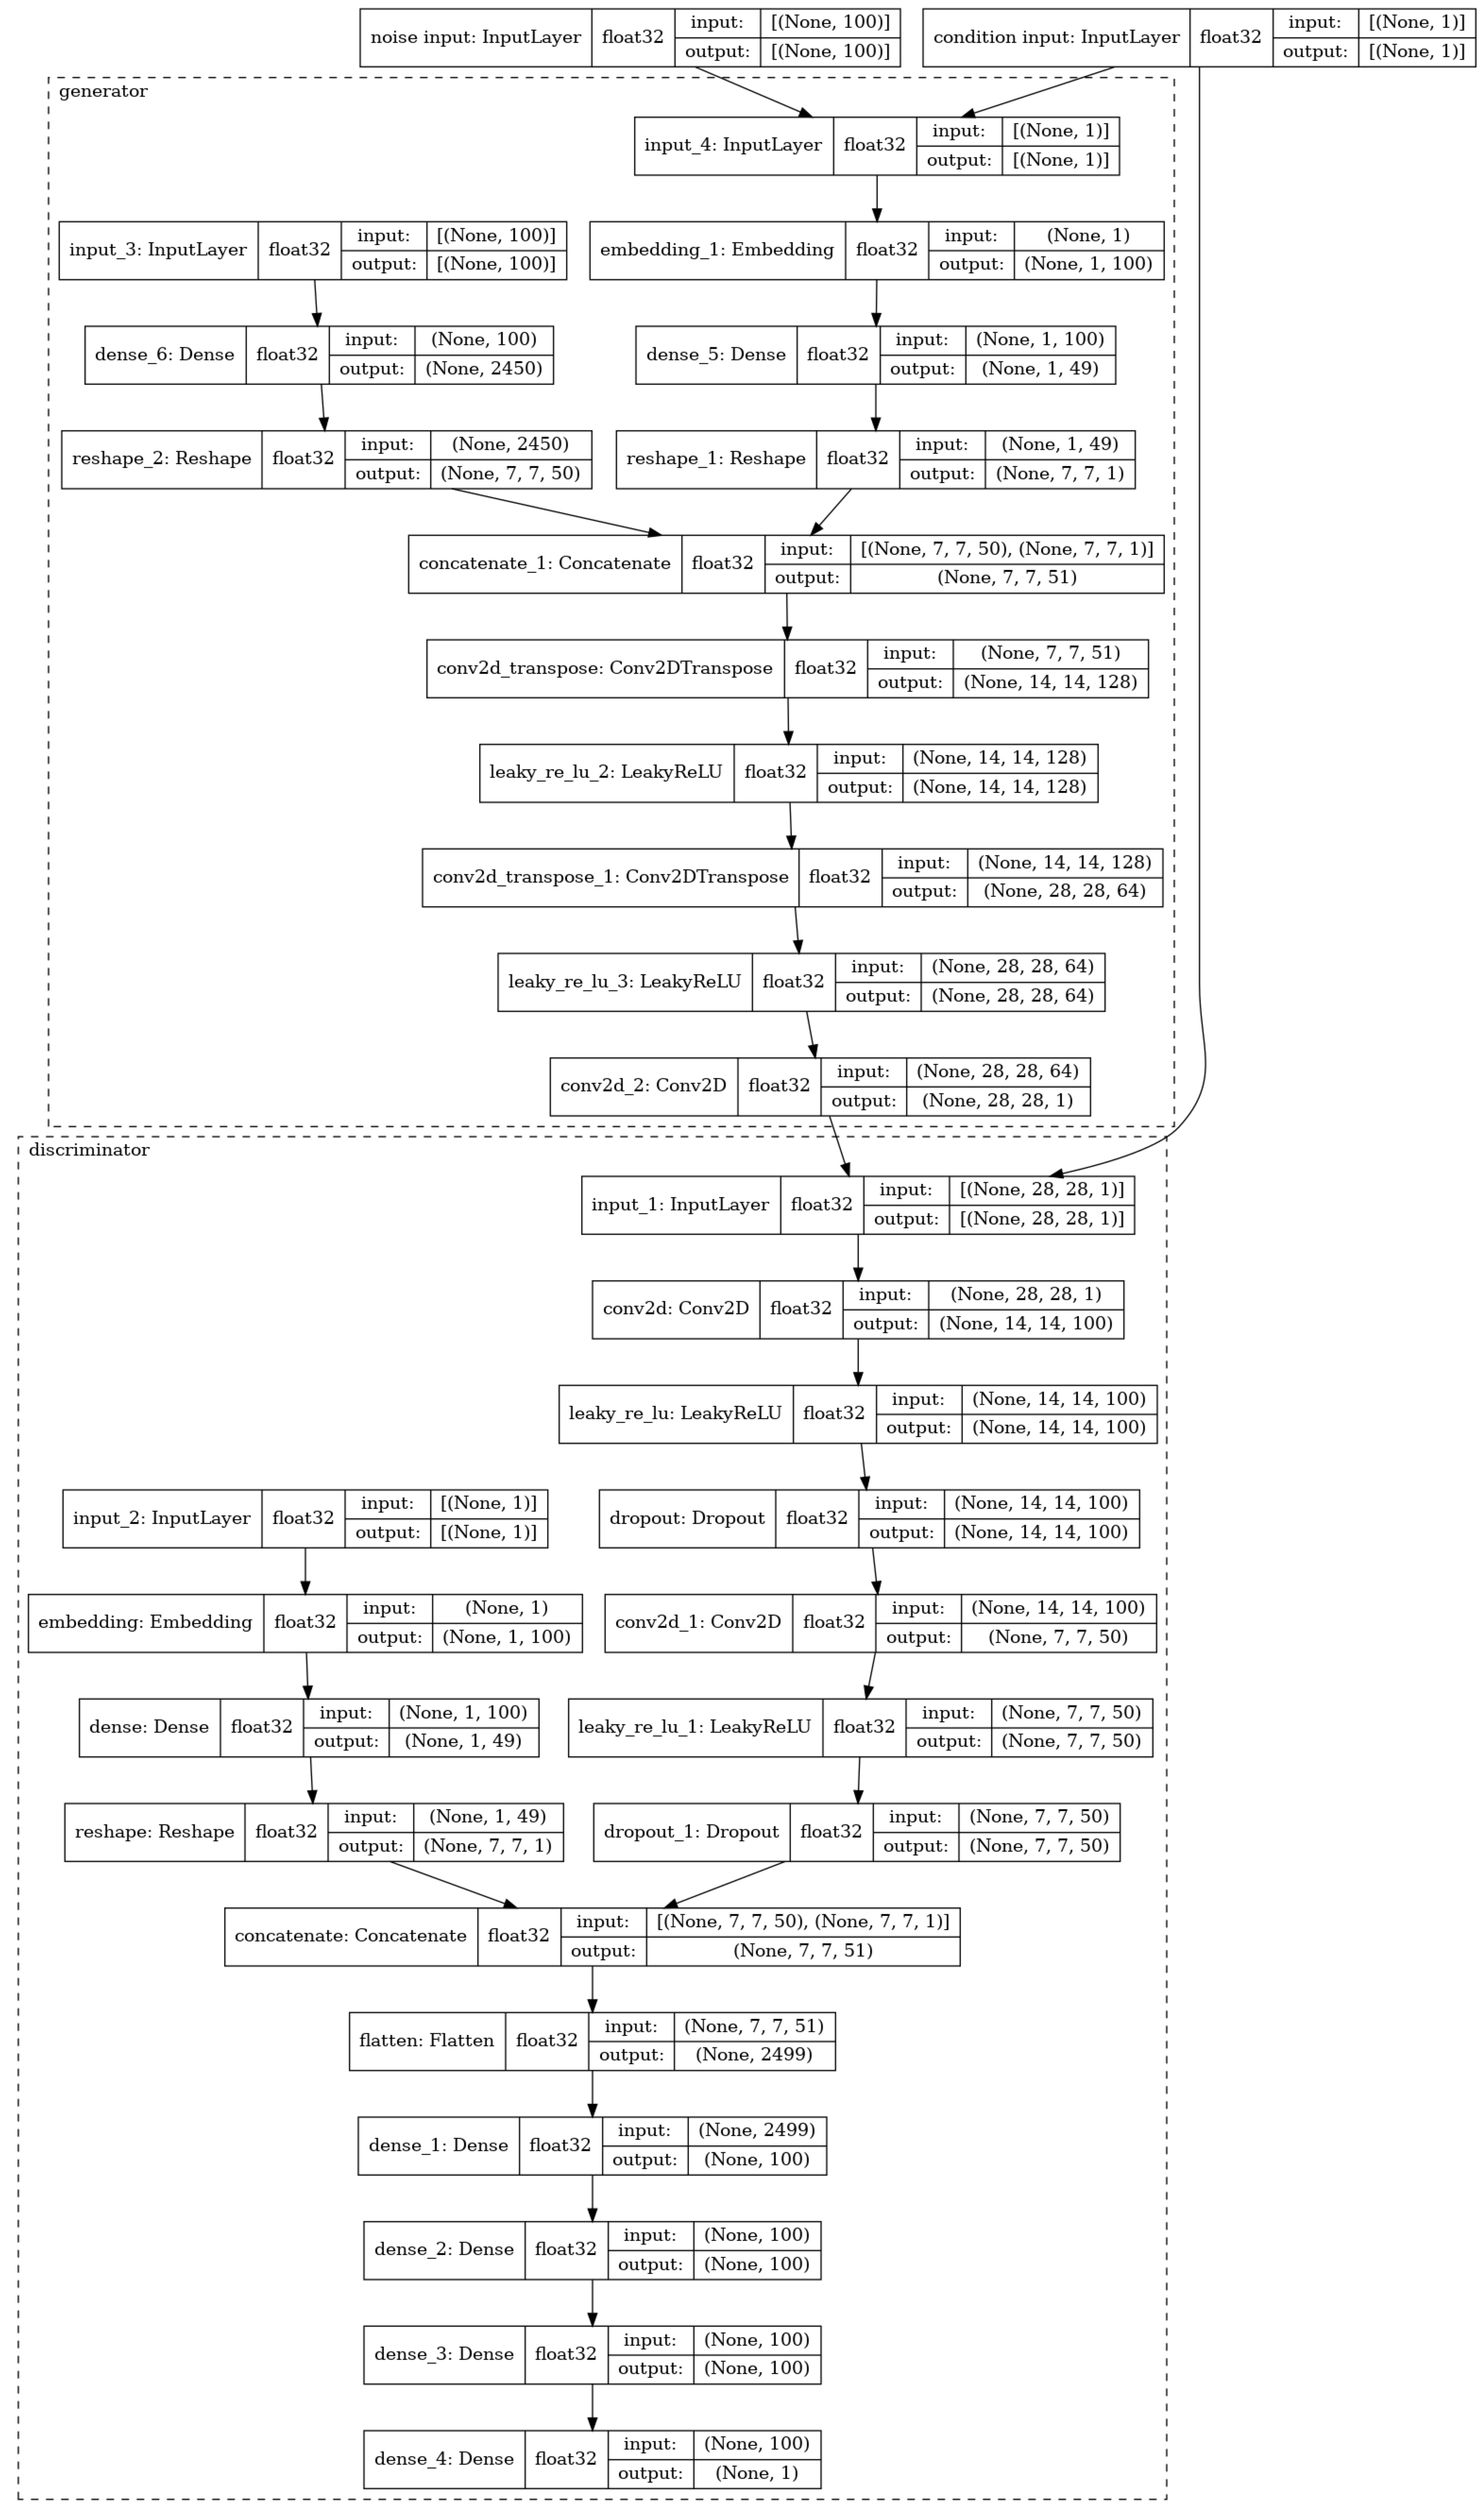

In [20]:
model_plotter(gan)

In [21]:
for i,l in enumerate(gan.layers):
  print("layer "+str(i+1),l.name,sep=" --> ")

layer 1 --> noise input
layer 2 --> condition input
layer 3 --> generator
layer 4 --> discriminator


In [22]:
noise_const = np.random.uniform(-1., 1., size=[9, 100])
index_const = np.random.randint(0,train_x.shape[0],9)

In [23]:
def save_picture(epoch):
  image = generator.predict([noise_const,tokens[index_const]])
  fig, axs = plt.subplots(3,3)
  count = 0
  for i in range(3):
    for j in range(3):
      axs[i,j].imshow(np.squeeze(image[count])*0.5+0.5)
      axs[i,j].axis('off')
      count += 1
  plt.show()
  plt.close()
  fig.savefig(f"{epoch}.png")

In [24]:
train_x = np.expand_dims(train_x,-1)
train_x = np.array(train_x)
train_x = (train_x / 127.5) - 1.

In [25]:
train_x.shape

(60000, 28, 28, 1)

0


2022-08-26 18:00:08.962531: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-26 18:00:10.975887: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-08-26 18:00:22.238491: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:00:22.340851: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:00:22.353610: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:00:22.441584: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:00:22.735704: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:00:22.750281: W tensorflow/core/data/root_dataset.cc:167] Op

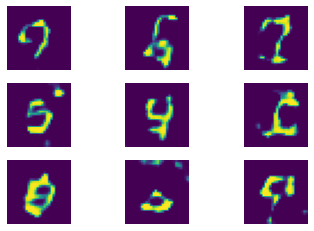

1


2022-08-26 18:02:48.723721: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:02:59.697137: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:02:59.906592: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:03:00.095594: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:03:00.134129: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:03:02.723517: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:03:02.797377: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:03:02.931142: W tensorflow/core/data/root_dataset.cc:16

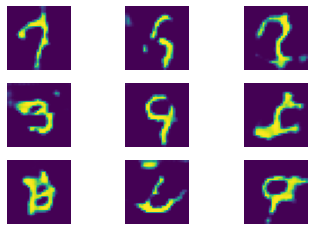

2


2022-08-26 18:05:11.536417: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:05:11.779644: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:05:12.636052: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:05:33.529753: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:05:33.669035: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:05:33.764929: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:05:45.411479: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:05:45.430914: W tensorflow/core/data/root_dataset.cc:16

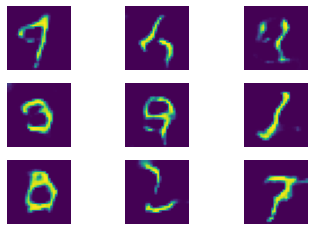

3


2022-08-26 18:07:13.022909: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:07:23.699884: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:07:23.951961: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:07:24.212620: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:07:24.377615: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:07:24.401599: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:07:24.542586: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:07:24.570382: W tensorflow/core/data/root_dataset.cc:16

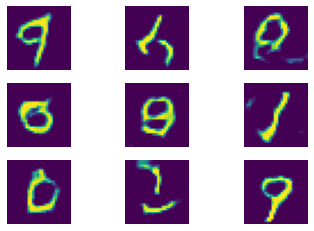

4


2022-08-26 18:09:35.854737: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:09:36.027757: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:09:36.480840: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:09:36.654676: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:09:46.563139: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:09:46.781123: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:09:57.763334: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:09:57.795572: W tensorflow/core/data/root_dataset.cc:16

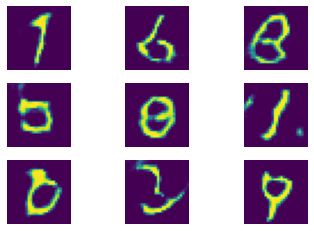

5


2022-08-26 18:11:58.511553: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:11:58.557904: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:11:58.990368: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:12:09.703131: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:12:21.463206: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:12:21.951885: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:12:21.967251: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:12:31.573129: W tensorflow/core/data/root_dataset.cc:16

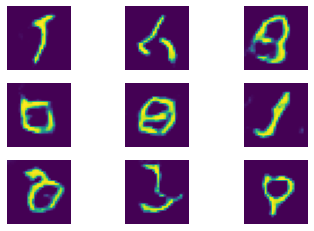

6


2022-08-26 18:14:32.843916: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:14:33.022497: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:14:33.372258: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:14:33.544597: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:14:54.725615: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:14:54.754129: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:14:54.817156: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:15:04.933101: W tensorflow/core/data/root_dataset.cc:16

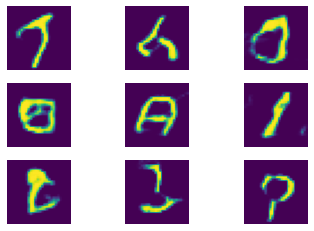

7


2022-08-26 18:16:55.877710: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:17:06.720743: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:17:15.416518: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:17:15.508672: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:17:15.542137: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:17:15.893168: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:17:15.907733: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:17:17.692868: W tensorflow/core/data/root_dataset.cc:16

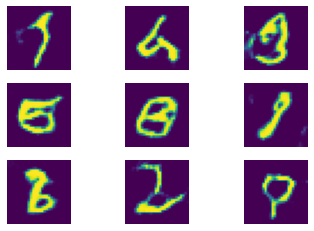

8


2022-08-26 18:19:25.700899: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:19:25.728704: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:19:25.934581: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:19:57.318485: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:19:57.517027: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:19:57.861712: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:19:57.959937: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:20:02.565368: W tensorflow/core/data/root_dataset.cc:16

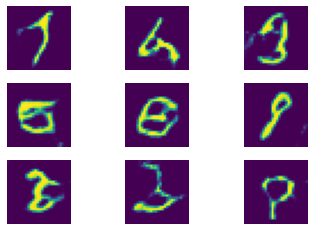

9


2022-08-26 18:21:30.537972: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:21:30.661379: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:21:34.816432: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:21:35.055818: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:21:35.333620: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:21:35.409720: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:21:35.591092: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:21:35.679558: W tensorflow/core/data/root_dataset.cc:16

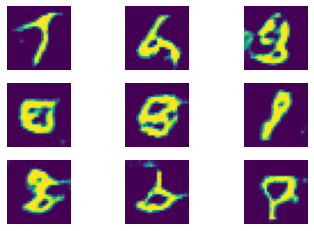

10


2022-08-26 18:23:45.358679: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:23:45.463245: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:23:53.925122: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:24:04.746608: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:24:37.485224: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:24:37.667055: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:24:48.792302: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:24:49.654598: W tensorflow/core/data/root_dataset.cc:16

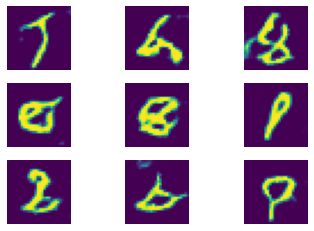

11


2022-08-26 18:26:27.753506: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:26:28.212159: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:26:28.226577: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:26:28.656288: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:26:28.753155: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:26:38.735965: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:26:38.837419: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:26:47.353332: W tensorflow/core/data/root_dataset.cc:16

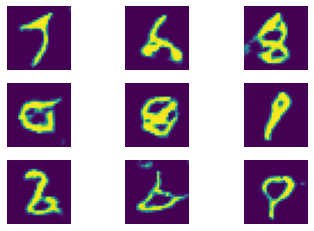

12


2022-08-26 18:28:37.776911: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:28:38.019694: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:28:38.152383: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:28:38.283846: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:28:38.474896: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:28:38.679593: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:28:38.799049: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:28:39.667735: W tensorflow/core/data/root_dataset.cc:16

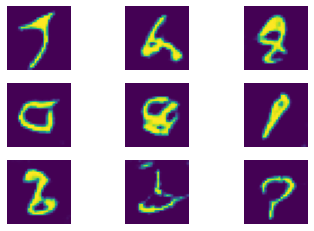

13


2022-08-26 18:31:02.610269: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:31:02.772953: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:31:02.891642: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:31:13.699438: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:31:20.596069: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:31:21.206871: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:31:21.345380: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:31:21.463494: W tensorflow/core/data/root_dataset.cc:16

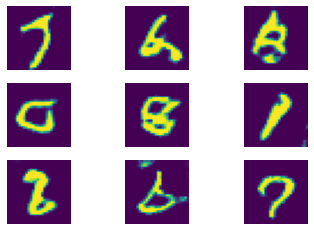

14


2022-08-26 18:33:47.799480: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:34:02.741666: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:34:02.758714: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:34:03.190625: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:34:20.661988: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:34:20.762443: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:34:31.963297: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:34:35.305215: W tensorflow/core/data/root_dataset.cc:16

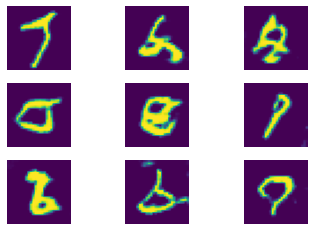

15


2022-08-26 18:36:14.405681: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:36:14.525704: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:36:22.085703: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:36:43.558497: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:36:46.229929: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:36:54.834397: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:37:06.109458: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:37:18.182405: W tensorflow/core/data/root_dataset.cc:16

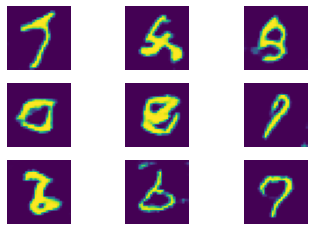

16


2022-08-26 18:38:56.769778: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:38:57.029094: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:38:57.406939: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:38:57.670579: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:39:06.713276: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:39:17.703840: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:39:28.875147: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:39:29.093334: W tensorflow/core/data/root_dataset.cc:16

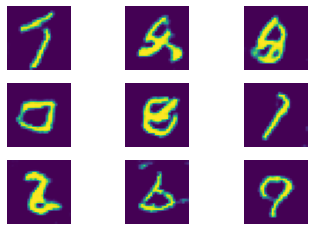

17


2022-08-26 18:41:06.172019: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:41:06.446389: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:41:06.494472: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:41:06.867877: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:41:06.992433: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:41:07.116757: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:41:07.135863: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:41:07.151724: W tensorflow/core/data/root_dataset.cc:16

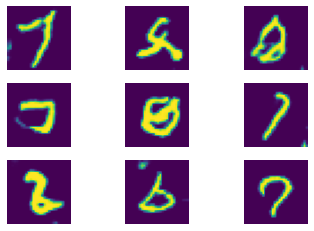

18


2022-08-26 18:43:49.085041: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:43:49.101309: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:43:49.115950: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:43:49.230428: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:43:49.333629: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:43:49.527868: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:43:52.742791: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:44:21.490660: W tensorflow/core/data/root_dataset.cc:16

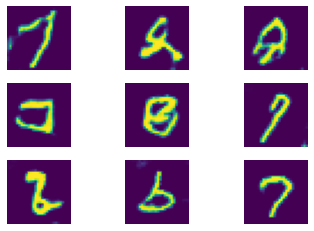

19


2022-08-26 18:45:53.803590: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:45:54.075485: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:45:58.052821: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:45:58.169132: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:45:58.188684: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:45:58.747092: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:45:58.888437: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:45:59.032772: W tensorflow/core/data/root_dataset.cc:16

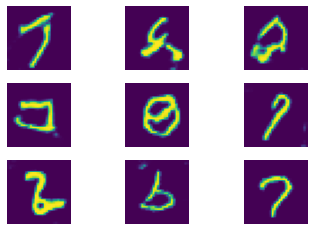

20


2022-08-26 18:48:48.541383: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:49:11.528226: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:49:11.648859: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:49:13.046584: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:49:13.131689: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:49:13.262894: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:49:33.691476: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:49:45.087918: W tensorflow/core/data/root_dataset.cc:16

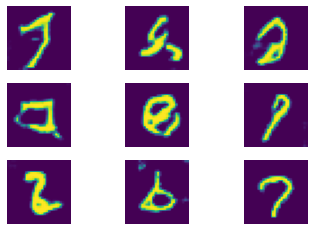

21


2022-08-26 18:51:22.970312: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:51:23.288770: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:51:23.392352: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:51:23.410033: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:51:23.630982: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:51:24.191050: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:51:24.306226: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:51:34.519975: W tensorflow/core/data/root_dataset.cc:16

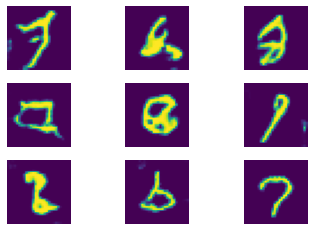

22


2022-08-26 18:53:57.534346: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:53:57.641436: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:53:57.957056: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:54:04.114492: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:54:04.605401: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:54:04.620196: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:54:08.795485: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:54:08.910643: W tensorflow/core/data/root_dataset.cc:16

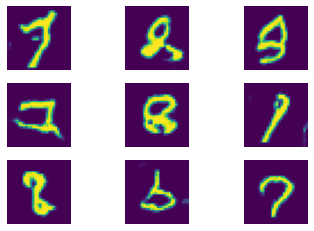

23


2022-08-26 18:56:42.684245: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:56:45.480312: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:56:45.598620: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:56:45.615195: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:56:45.765435: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:56:45.883153: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:56:46.045699: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:56:46.143510: W tensorflow/core/data/root_dataset.cc:16

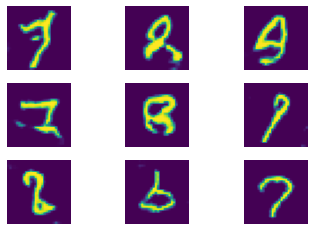

24


2022-08-26 18:59:28.113373: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:59:28.145058: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:59:38.547832: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:59:38.690146: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:59:49.111147: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 18:59:49.724431: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:00:00.711587: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:00:00.872725: W tensorflow/core/data/root_dataset.cc:16

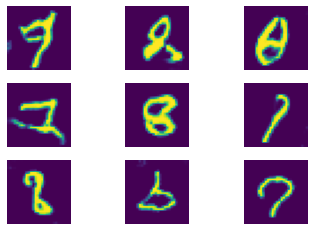

25


2022-08-26 19:01:51.151874: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:02:01.641391: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:02:10.708805: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:02:10.815395: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:02:11.243506: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:02:12.552015: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:02:12.802214: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:02:34.800462: W tensorflow/core/data/root_dataset.cc:16

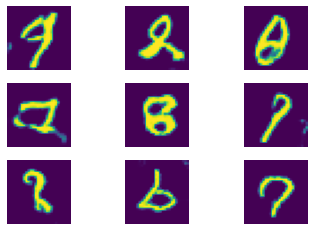

26


2022-08-26 19:04:20.334122: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:04:20.451776: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:04:46.695652: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:04:46.779986: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:04:52.021578: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:04:52.125918: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:04:52.653512: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:04:52.769614: W tensorflow/core/data/root_dataset.cc:16

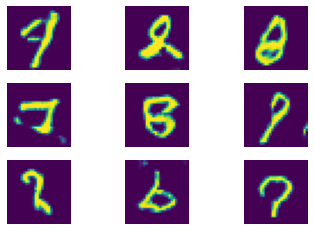

27


2022-08-26 19:06:48.089650: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:06:58.495894: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:06:58.807303: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:06:59.046469: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:06:59.061705: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:07:00.453832: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:07:00.559816: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:07:00.573584: W tensorflow/core/data/root_dataset.cc:16

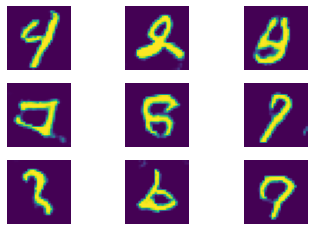

28


2022-08-26 19:08:59.684883: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:09:08.377389: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:09:08.694925: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:09:08.995117: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:09:09.115749: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:09:09.494416: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:09:09.570834: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:09:21.534271: W tensorflow/core/data/root_dataset.cc:16

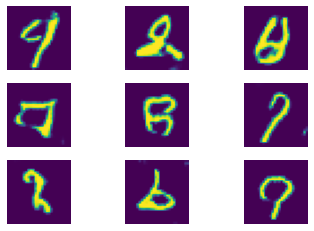

29


2022-08-26 19:11:33.736753: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:11:33.816793: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:11:33.831553: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:11:45.095612: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:11:49.700967: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:11:49.786744: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:11:49.814917: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:11:49.928591: W tensorflow/core/data/root_dataset.cc:16

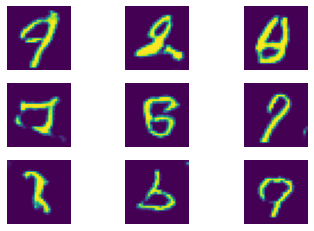

30


2022-08-26 19:13:45.485205: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:13:56.764566: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:13:57.483205: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:13:57.498296: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:13:57.511064: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:13:57.612147: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:13:57.936214: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:13:58.042087: W tensorflow/core/data/root_dataset.cc:16

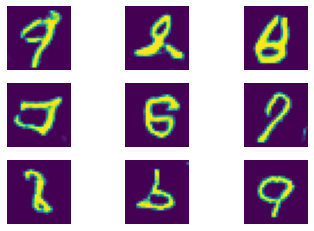

31


2022-08-26 19:16:09.036787: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:16:09.495032: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:16:09.848900: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:16:40.884023: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:16:41.006142: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:16:41.932652: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:16:42.045748: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:17:13.198798: W tensorflow/core/data/root_dataset.cc:16

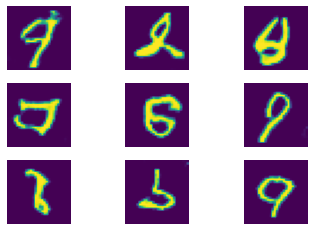

32


2022-08-26 19:18:09.750216: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:18:09.764555: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:18:09.777333: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:18:09.843450: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:18:10.025068: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:18:17.666838: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:18:18.393741: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:18:20.519441: W tensorflow/core/data/root_dataset.cc:16

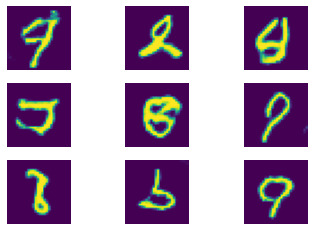

33


2022-08-26 19:20:21.658713: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:20:21.858094: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:20:26.623228: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:20:26.922641: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:20:27.183656: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:20:27.196886: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:20:27.265282: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:20:27.358777: W tensorflow/core/data/root_dataset.cc:16

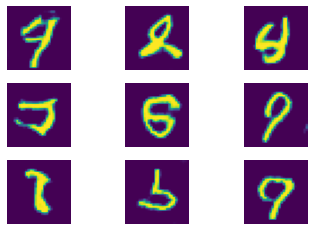

34


2022-08-26 19:22:35.193155: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:22:35.645633: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:22:35.750522: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:22:35.870451: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:22:35.961070: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:22:44.698432: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:22:44.769065: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:23:06.704510: W tensorflow/core/data/root_dataset.cc:16

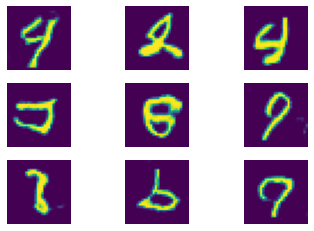

35


2022-08-26 19:24:44.806370: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:24:45.438991: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:25:17.906801: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:25:18.767850: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:25:18.931228: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:25:19.087531: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:25:50.037410: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:25:50.119838: W tensorflow/core/data/root_dataset.cc:16

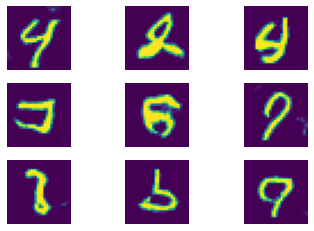

36


2022-08-26 19:27:19.780089: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:27:26.091385: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:27:26.676741: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:27:26.691642: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:27:26.776975: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:27:41.700565: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:27:58.650130: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:27:58.664408: W tensorflow/core/data/root_dataset.cc:16

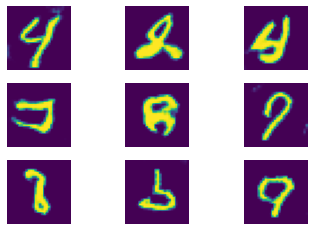

37


2022-08-26 19:29:20.774424: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:29:20.788488: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:29:20.863833: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:29:42.689169: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:29:42.769212: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:30:04.640045: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:30:04.837997: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:30:15.637873: W tensorflow/core/data/root_dataset.cc:16

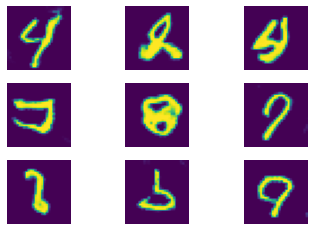

38


2022-08-26 19:31:32.965737: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:31:32.980185: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:31:43.489138: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:32:06.021589: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:32:06.235605: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:32:17.050683: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:32:27.702154: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:32:27.718096: W tensorflow/core/data/root_dataset.cc:16

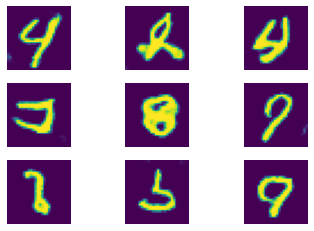

39


2022-08-26 19:33:44.999213: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:33:55.681159: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:33:55.767949: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:34:17.768451: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:34:29.047397: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:34:29.262600: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:34:35.385709: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:34:35.553371: W tensorflow/core/data/root_dataset.cc:16

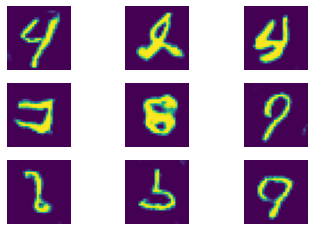

40


2022-08-26 19:35:57.049584: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:35:57.073897: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:36:07.493633: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:36:07.652190: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:36:07.747820: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:36:07.769613: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:36:12.031973: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:36:12.194253: W tensorflow/core/data/root_dataset.cc:16

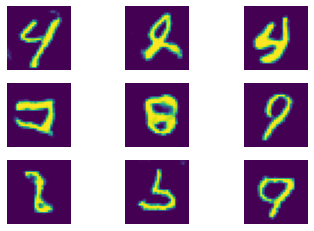

41


2022-08-26 19:38:42.062512: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:38:52.536783: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:38:54.418377: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:38:54.609477: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:38:54.624876: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:38:54.946529: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:38:54.961393: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:38:55.035782: W tensorflow/core/data/root_dataset.cc:16

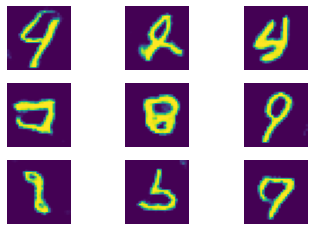

42


2022-08-26 19:40:20.604427: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:40:31.669270: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:40:31.994588: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:40:33.923955: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:40:34.120321: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:40:34.215979: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:40:34.230682: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:40:34.308228: W tensorflow/core/data/root_dataset.cc:16

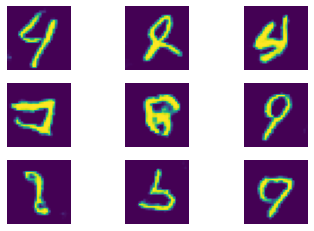

43


2022-08-26 19:42:43.547990: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:42:43.669612: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:42:44.444962: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:42:44.627065: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:42:44.704172: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:42:44.718905: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:42:44.887127: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:42:44.901298: W tensorflow/core/data/root_dataset.cc:16

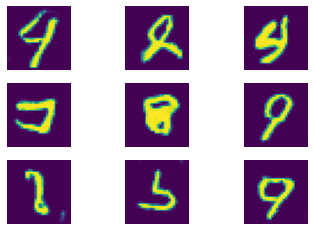

44


2022-08-26 19:44:54.929577: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:44:54.944385: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:45:06.493952: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:45:17.764730: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:45:17.862597: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:45:26.803649: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:45:27.056660: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:45:27.251016: W tensorflow/core/data/root_dataset.cc:16

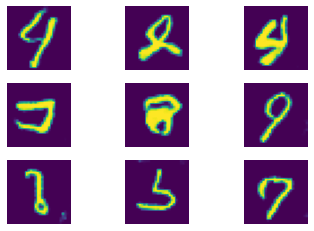

45


2022-08-26 19:47:03.847052: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:47:04.035304: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:47:04.229079: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:47:07.730054: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:47:18.733897: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:47:29.678335: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:47:29.693342: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:47:35.169710: W tensorflow/core/data/root_dataset.cc:16

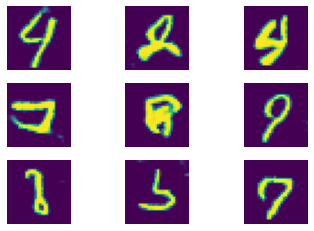

46


2022-08-26 19:49:19.937559: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:49:30.667756: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:49:44.781998: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:49:45.298506: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:49:52.632046: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:50:04.039576: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:50:17.423795: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:50:18.109953: W tensorflow/core/data/root_dataset.cc:16

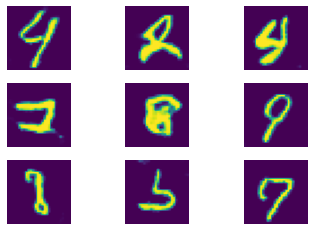

47


2022-08-26 19:51:42.575852: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:51:42.981613: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:51:53.562219: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:51:56.737860: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:51:56.750720: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:51:57.437381: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:51:57.527246: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:52:26.724923: W tensorflow/core/data/root_dataset.cc:16

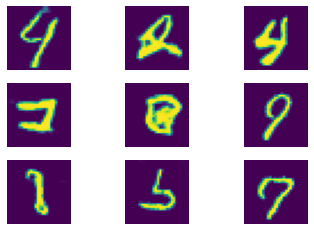

48


2022-08-26 19:53:54.610355: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:54:05.684763: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:54:05.761671: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:54:06.778008: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:54:06.792565: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:54:06.980180: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:54:16.514495: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:54:16.662760: W tensorflow/core/data/root_dataset.cc:16

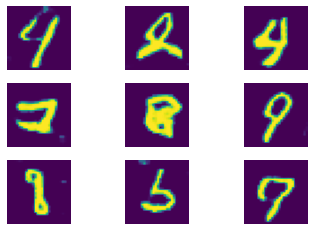

49


2022-08-26 19:56:15.214256: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:56:15.731587: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:56:15.756579: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:56:28.525088: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:56:28.747396: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:56:39.748140: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:56:39.958593: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:56:47.505942: W tensorflow/core/data/root_dataset.cc:16

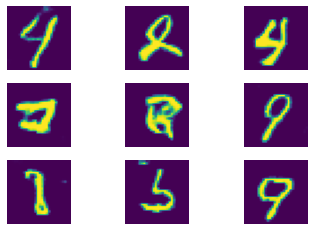

50


2022-08-26 19:58:25.291001: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:58:25.422355: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:58:25.504770: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:58:26.390560: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:58:26.405376: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:58:40.659610: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:58:40.766886: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 19:58:40.781175: W tensorflow/core/data/root_dataset.cc:16

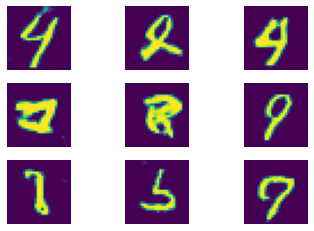

51


2022-08-26 20:00:30.550441: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:00:30.782525: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:00:35.845363: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:00:35.945025: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:00:36.111670: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:00:36.280821: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:00:36.552719: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:00:52.539052: W tensorflow/core/data/root_dataset.cc:16

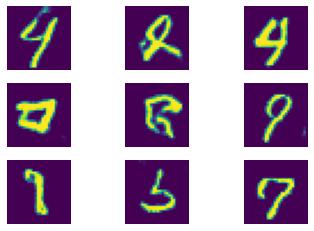

52


2022-08-26 20:02:44.442137: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:02:44.536247: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:02:45.089913: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:02:45.181353: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:02:45.276104: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:02:45.357656: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:02:45.452086: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:02:45.544765: W tensorflow/core/data/root_dataset.cc:16

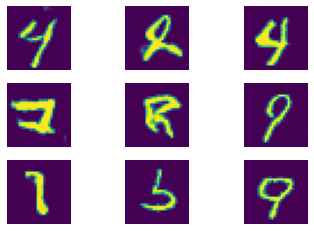

53


2022-08-26 20:04:53.517312: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:04:53.845893: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:04:53.942668: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:04:54.379141: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:04:54.394577: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:05:05.724268: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:05:05.834363: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:05:25.801843: W tensorflow/core/data/root_dataset.cc:16

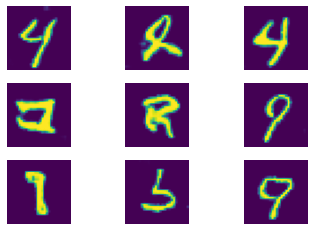

54


2022-08-26 20:07:34.909938: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:07:34.924379: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:07:35.027243: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:07:39.596013: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:07:39.709581: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:07:39.885594: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:07:50.659831: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:07:50.721704: W tensorflow/core/data/root_dataset.cc:16

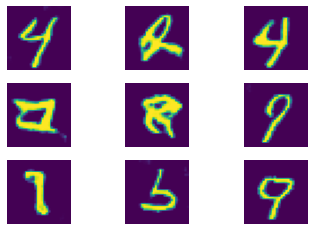

55


2022-08-26 20:09:29.730050: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:09:44.609487: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:09:45.504652: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:09:45.519056: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:09:45.591769: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:09:51.675729: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:09:51.688877: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:10:13.577992: W tensorflow/core/data/root_dataset.cc:16

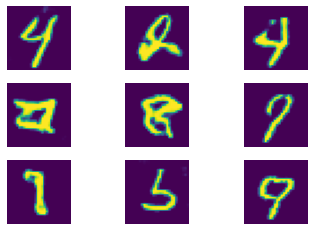

56


2022-08-26 20:11:41.731028: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:11:41.745162: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:11:53.597427: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:11:54.142480: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:11:54.449270: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:11:54.530181: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:12:03.685592: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:12:25.709582: W tensorflow/core/data/root_dataset.cc:16

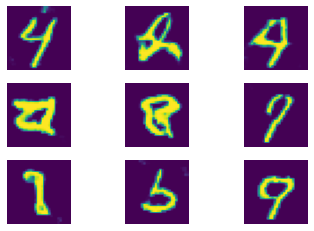

57


2022-08-26 20:14:04.187689: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:14:04.369570: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:14:04.901614: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:14:04.926579: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:14:05.036811: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:14:05.195756: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:14:05.394125: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:14:15.699162: W tensorflow/core/data/root_dataset.cc:16

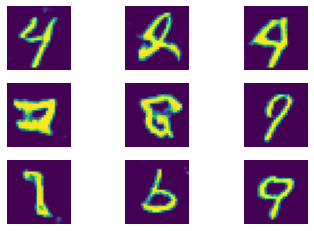

58


2022-08-26 20:16:14.433037: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:16:14.508373: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:16:14.522767: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:16:14.627111: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:16:15.118371: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:16:16.723799: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:16:27.698737: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:16:28.069772: W tensorflow/core/data/root_dataset.cc:16

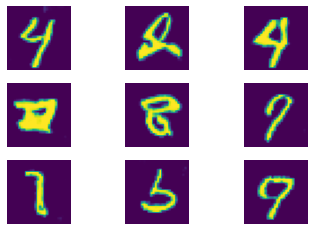

59


2022-08-26 20:18:23.611073: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:18:23.627344: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:18:24.228489: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:18:24.323096: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:18:24.417001: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:18:24.608628: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:18:24.623184: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:18:24.636598: W tensorflow/core/data/root_dataset.cc:16

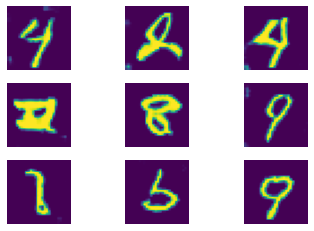

60


2022-08-26 20:20:51.706191: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:21:02.840755: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:21:03.050750: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:21:05.431043: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:21:05.806377: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:21:06.067734: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:21:06.081955: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:21:06.264570: W tensorflow/core/data/root_dataset.cc:16

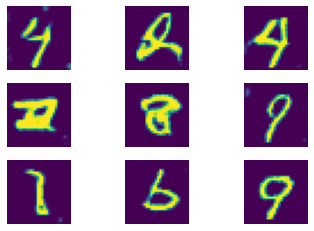

61


2022-08-26 20:23:03.863637: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:23:03.960809: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:23:03.975055: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:23:14.388844: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:23:14.514809: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:23:14.699177: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:23:15.715453: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:23:25.689097: W tensorflow/core/data/root_dataset.cc:16

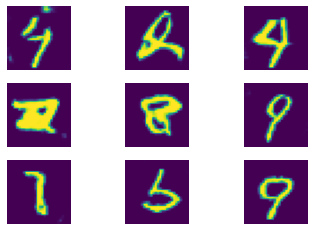

62


2022-08-26 20:25:15.703680: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:25:16.041200: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:25:23.461739: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:25:23.538024: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:25:24.114575: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:25:24.191524: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:25:24.389584: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:25:24.481967: W tensorflow/core/data/root_dataset.cc:16

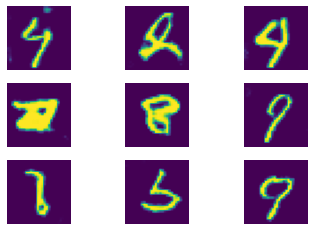

63


2022-08-26 20:27:33.283886: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:27:33.370884: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:27:33.722387: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:27:33.870799: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:27:34.171393: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:27:34.185868: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:27:50.610589: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:28:06.176649: W tensorflow/core/data/root_dataset.cc:16

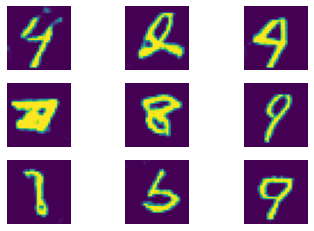

64


2022-08-26 20:29:42.650663: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:29:42.797358: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:29:42.811192: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:29:43.481059: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:29:43.593278: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:29:51.396699: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:29:51.473204: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:30:01.700693: W tensorflow/core/data/root_dataset.cc:16

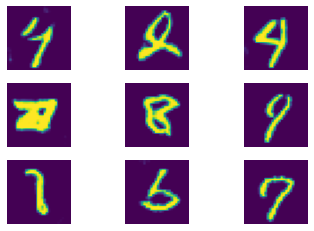

65


2022-08-26 20:32:22.634394: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:32:22.704944: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:32:22.811347: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:32:23.370739: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:32:23.481847: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:32:23.576933: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:32:23.656049: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:32:47.413691: W tensorflow/core/data/root_dataset.cc:16

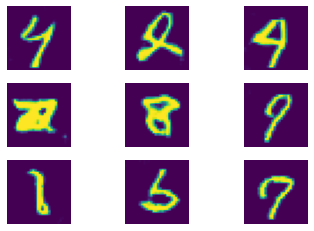

66


2022-08-26 20:34:26.343462: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:34:26.450577: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:34:31.084863: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:34:31.303604: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:34:32.000429: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:34:32.094125: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:34:37.493590: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:34:48.501378: W tensorflow/core/data/root_dataset.cc:16

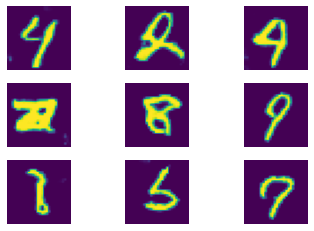

67


2022-08-26 20:36:38.305500: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:36:39.478617: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:36:39.580311: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:36:39.937599: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:36:39.985025: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:36:40.190643: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:36:40.491639: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:36:40.585550: W tensorflow/core/data/root_dataset.cc:16

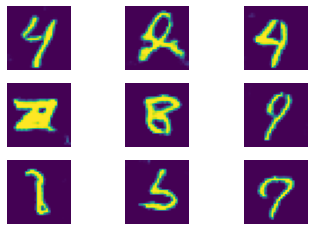

68


2022-08-26 20:39:00.146265: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:39:00.758934: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:39:01.333687: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:39:20.435656: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:39:20.448785: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:39:21.031639: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:39:21.172101: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:39:21.271116: W tensorflow/core/data/root_dataset.cc:16

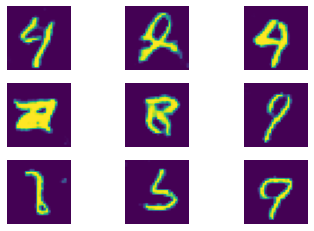

69


2022-08-26 20:41:35.411390: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:41:35.620594: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:41:46.402707: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:41:46.612606: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:41:46.720178: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:41:56.155836: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:42:00.886636: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:42:01.130643: W tensorflow/core/data/root_dataset.cc:16

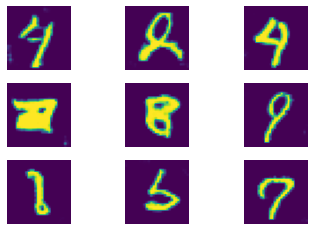

70


2022-08-26 20:43:36.320735: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:43:37.615441: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:43:37.716006: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:43:38.007590: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:43:38.021707: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:43:38.096232: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:43:38.193031: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:43:46.108856: W tensorflow/core/data/root_dataset.cc:16

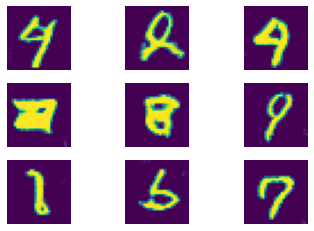

71


2022-08-26 20:45:59.609921: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:46:10.318391: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:46:19.290495: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:46:19.593685: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:46:19.725899: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:46:19.759585: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:46:19.908815: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:46:19.950659: W tensorflow/core/data/root_dataset.cc:16

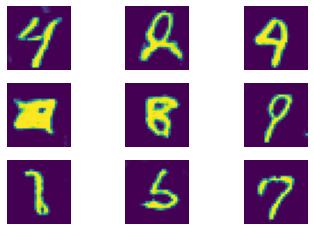

72


2022-08-26 20:48:28.100892: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:48:28.329108: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:48:28.352595: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:48:28.677299: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:48:28.813476: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:48:28.886252: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:48:28.974612: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:48:55.648046: W tensorflow/core/data/root_dataset.cc:16

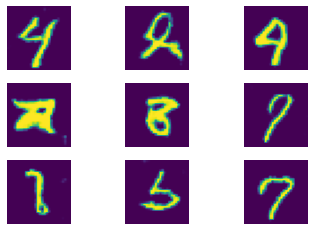

73


2022-08-26 20:50:37.236983: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:50:37.252405: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:50:37.738633: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:50:37.907589: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:50:37.925469: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:50:38.047607: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:50:38.143210: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:50:38.246625: W tensorflow/core/data/root_dataset.cc:16

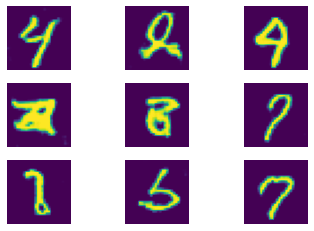

74


2022-08-26 20:52:57.377517: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:53:08.488750: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:53:18.289169: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:53:18.310614: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:53:18.399852: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:53:18.414460: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:53:18.490899: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:53:18.958339: W tensorflow/core/data/root_dataset.cc:16

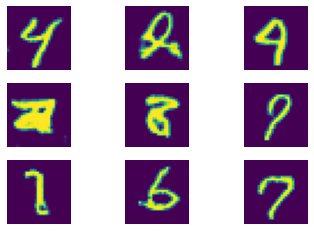

75


2022-08-26 20:55:20.360627: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:55:28.738055: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:55:28.965666: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:55:28.989584: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:55:29.165635: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:55:29.340030: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:55:31.703597: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:55:42.464350: W tensorflow/core/data/root_dataset.cc:16

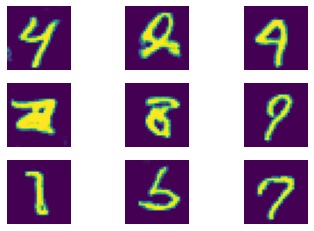

76


2022-08-26 20:57:38.558033: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:57:38.643791: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:57:38.658053: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:57:38.822591: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:57:39.004652: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:57:47.729535: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:58:10.479611: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 20:58:10.580502: W tensorflow/core/data/root_dataset.cc:16

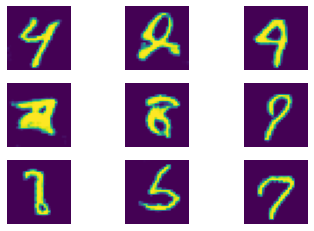

77


2022-08-26 20:59:48.558087: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:00:19.578664: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:00:19.592131: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:00:19.660440: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:00:19.675701: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:00:20.182635: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:00:28.335673: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:00:28.426432: W tensorflow/core/data/root_dataset.cc:16

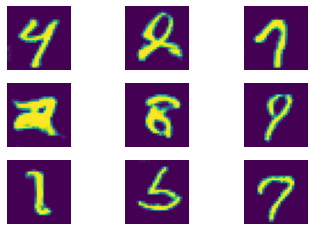

78


2022-08-26 21:02:28.444890: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:02:28.474268: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:02:29.328331: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:02:29.343141: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:03:01.495219: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:03:01.523263: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:03:01.864655: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:03:02.251578: W tensorflow/core/data/root_dataset.cc:16

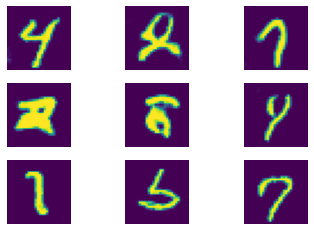

79


2022-08-26 21:04:40.353463: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:04:41.141557: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:04:41.229975: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:04:41.675702: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:04:52.546216: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:05:13.374250: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:05:13.471250: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:05:13.881151: W tensorflow/core/data/root_dataset.cc:16

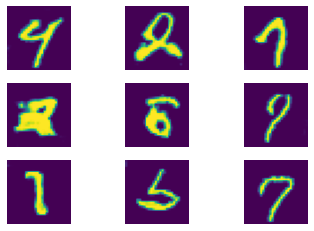

80


2022-08-26 21:06:52.339230: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:06:52.436672: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:06:52.812112: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:06:53.150294: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:06:53.165717: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:06:53.260811: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:06:53.339419: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:06:53.356841: W tensorflow/core/data/root_dataset.cc:16

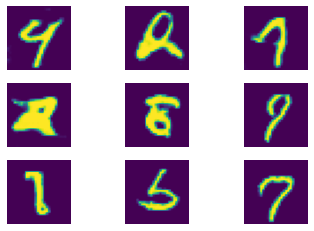

81


2022-08-26 21:09:16.390710: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:09:16.462923: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:09:16.594450: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:09:27.467011: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:09:33.189601: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:09:33.288729: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:09:33.644931: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:09:49.353950: W tensorflow/core/data/root_dataset.cc:16

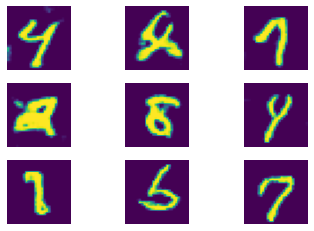

82


2022-08-26 21:11:39.408496: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:11:39.504228: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:11:41.431028: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:11:41.446410: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:11:41.544279: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:11:41.625636: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:11:42.229083: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:11:42.312655: W tensorflow/core/data/root_dataset.cc:16

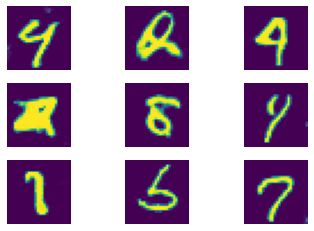

83


2022-08-26 21:13:51.508111: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:13:51.981580: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:13:52.915160: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:13:52.950322: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:13:53.023848: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:13:53.649298: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:14:26.822782: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:14:27.003070: W tensorflow/core/data/root_dataset.cc:16

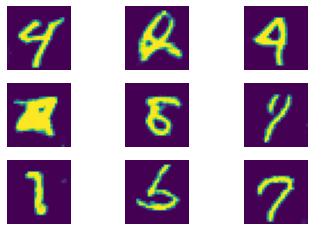

84


2022-08-26 21:16:14.501264: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:16:36.362850: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:16:36.444156: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:16:36.766608: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:16:38.212917: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:16:38.535895: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:16:38.631336: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:16:38.646358: W tensorflow/core/data/root_dataset.cc:16

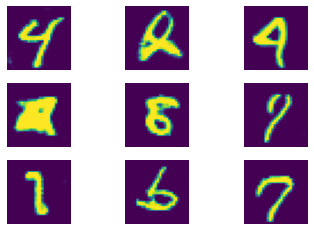

85


2022-08-26 21:18:47.005032: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:18:47.657134: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:18:48.471818: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:18:59.758621: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:19:10.328009: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:19:19.695680: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:19:19.911376: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:19:20.172595: W tensorflow/core/data/root_dataset.cc:16

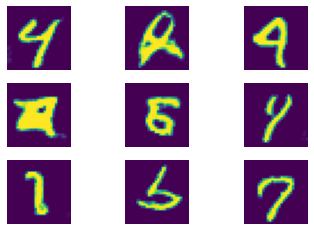

86


2022-08-26 21:20:49.509590: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:20:55.808242: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:20:56.505475: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:21:00.464600: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:21:11.392260: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:21:27.658462: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:21:27.750898: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:21:27.877514: W tensorflow/core/data/root_dataset.cc:16

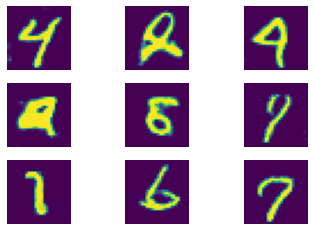

87


2022-08-26 21:23:12.522482: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:23:12.632976: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:23:12.717158: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:23:12.735591: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:23:23.382763: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:23:23.465392: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:23:23.480162: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:23:33.712656: W tensorflow/core/data/root_dataset.cc:16

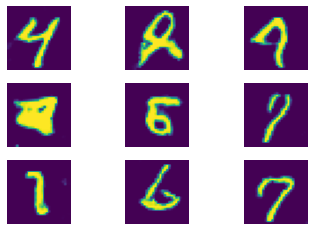

88


2022-08-26 21:25:24.450872: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:25:35.462267: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:25:35.478325: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:25:46.539969: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:25:47.268206: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:25:47.511664: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:25:57.453770: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:26:08.339969: W tensorflow/core/data/root_dataset.cc:16

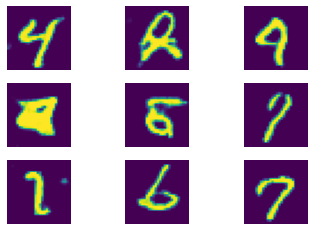

89


2022-08-26 21:27:59.167996: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:27:59.283676: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:28:09.393431: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:28:09.504968: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:28:20.510569: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:28:30.675459: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:28:31.113584: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:28:31.138715: W tensorflow/core/data/root_dataset.cc:16

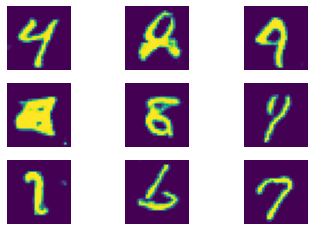

90


2022-08-26 21:30:07.621321: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:30:07.636947: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:30:08.059637: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:30:10.331947: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:30:21.316932: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:30:21.412428: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:30:21.427366: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:30:21.512859: W tensorflow/core/data/root_dataset.cc:16

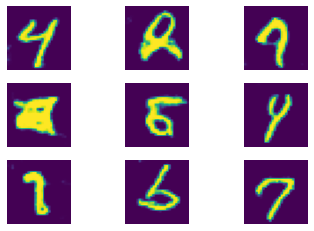

91


2022-08-26 21:32:44.366620: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:32:48.856750: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:32:49.132126: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:32:49.261593: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:33:21.591485: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:33:22.093431: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:33:22.281581: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:33:39.649607: W tensorflow/core/data/root_dataset.cc:16

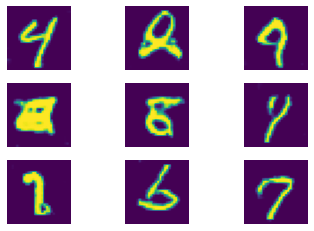

92


2022-08-26 21:34:58.128574: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:34:58.258489: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:34:58.763572: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:34:58.940129: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:35:07.457851: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:35:07.473228: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:35:07.700692: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:35:18.479841: W tensorflow/core/data/root_dataset.cc:16

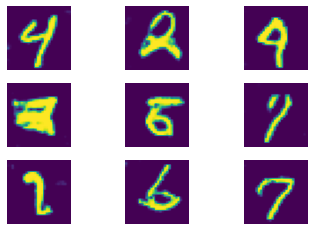

93


2022-08-26 21:37:30.368591: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:37:30.689621: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:37:40.888058: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:37:41.014361: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:37:41.110936: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:37:41.771179: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:37:42.185142: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:38:13.760805: W tensorflow/core/data/root_dataset.cc:16

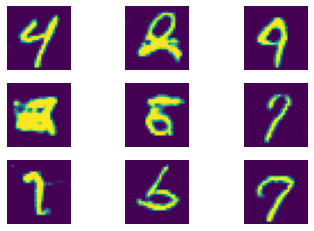

94


2022-08-26 21:40:15.453801: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:40:22.759202: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:40:22.904657: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:40:22.920621: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:40:23.488352: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:40:23.632098: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:40:26.504053: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:40:26.752230: W tensorflow/core/data/root_dataset.cc:16

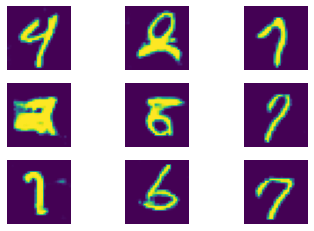

95


2022-08-26 21:43:00.707579: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:43:04.841061: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:43:04.970719: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:43:05.061411: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:43:05.539070: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:43:05.741757: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:43:11.444569: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:43:22.671584: W tensorflow/core/data/root_dataset.cc:16

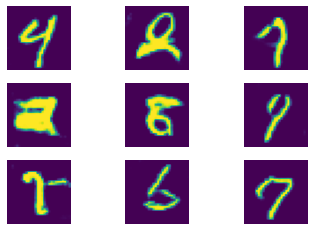

96


2022-08-26 21:45:45.496291: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:45:50.510632: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:45:50.549960: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:45:50.652416: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:45:50.690361: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:45:50.981870: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:45:51.144986: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:45:56.469751: W tensorflow/core/data/root_dataset.cc:16

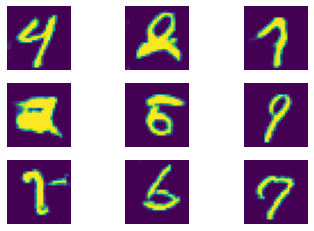

97


2022-08-26 21:48:35.652916: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:48:35.932332: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:48:36.161597: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:49:02.138869: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:49:03.427626: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:49:08.291093: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:49:08.439079: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:49:24.709026: W tensorflow/core/data/root_dataset.cc:16

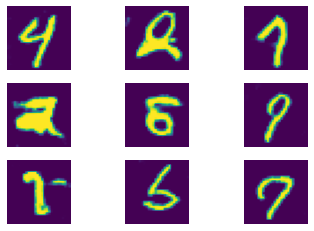

98


2022-08-26 21:51:19.698694: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:51:19.807577: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:51:19.822250: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:51:19.929088: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:51:20.791743: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:51:38.318059: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:51:48.460207: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:51:53.227522: W tensorflow/core/data/root_dataset.cc:16

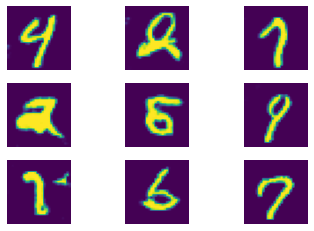

99


2022-08-26 21:53:49.350587: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:53:49.559598: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:54:00.341957: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:54:00.587289: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:54:04.556474: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:54:04.844649: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:54:05.248588: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-26 21:54:05.455413: W tensorflow/core/data/root_dataset.cc:16

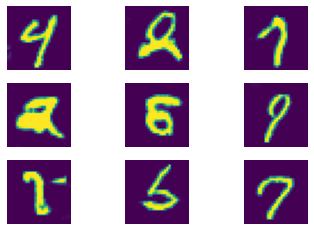

In [26]:
BATCH_SIZE = 32
STEPS_PER_EPOCH = train_x.shape[0]//BATCH_SIZE
EPOCHS = 100

FAKE_LABELS = np.zeros((32,1))
REAL_LABELS = np.ones((32,1))

for i in range(EPOCHS):
  print(i)
  for j in range(STEPS_PER_EPOCH):
    index = np.random.randint(0,train_x.shape[0],BATCH_SIZE)
    discriminator.train_on_batch(get_discriminator_batch(BATCH_SIZE,index,fake=True),FAKE_LABELS)
    discriminator.train_on_batch(get_discriminator_batch(BATCH_SIZE,index,fake=False),REAL_LABELS)
    gan.train_on_batch(get_generator_training_batch(BATCH_SIZE,index),REAL_LABELS)
  if(i%1 == 0):
    save_picture(i)

In [27]:
noise = np.random.uniform(-1., 1., size=[1, 100])
cond  = "three"
tok = np.array([d[cond]])
img = generator.predict([noise,tok])

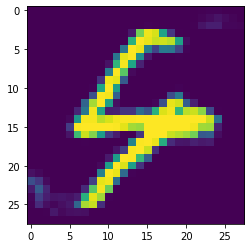

In [28]:
plt.imshow(np.squeeze(img)*0.5+0.5)
plt.show()